In [1]:
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

import os
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram
from utils import butter_bandpass_filter, get_timit_dict, get_target, create_mel_filter, pretty_spectrogram, invert_pretty_spectrogram, sliding_window
import matplotlib.pyplot as plt
from python_speech_features import mfcc, logfbank

In [2]:
labels = get_timit_dict('phonedict.txt')

rate = 16000 #16000fps - 0.0625ms per frame
stepsize = 64 #for spectogram reduction

frame_size = (int)((0.030 * rate) / stepsize) #30ms
frame_step = (int)((0.010 * rate) / stepsize) #15ms

In [8]:
# preprocess data
audio = []
spectograms = []
mfccs = []
phones = []
for dirName, subdirList, fileList in os.walk('./data/TRAIN/'):
    for fname in fileList:
        if not fname.endswith('.phn') and not fname.endswith('.PHN') or (fname.startswith('SA')):
            continue

        phn_fname = dirName + fname
        wav_fname = dirName + fname[0:-4] + '.WAV'

        _, data = wavfile.read(wav_fname)

        audio.append(data)
        spectogram = pretty_spectrogram(data.astype('float64'), step_size=stepsize)
        phone_ids = get_target(phn_fname, labels, data.shape[0])
        for x, window in sliding_window(spectogram, frame_step, frame_size):
            spectograms.append(window)
            idx = x*stepsize + (int)(stepsize*frame_size/2)
            phones.append(phone_ids[idx])

        mfccs.append(mfcc(data, rate))

        print('Loaded: {}'.format(fname[0:-4]))
audio = np.concatenate(audio)
spectograms = np.stack(spectograms)
mfccs = np.concatenate(mfccs)
phones = np.array(phones)

Loaded: DR2MJRP0SI1845
Loaded: DR2MJRP0SI585
Loaded: LDC93S1


In [9]:
print(phones.shape)
print(spectograms.shape)

(1247, 61)
(1247, 7, 256)


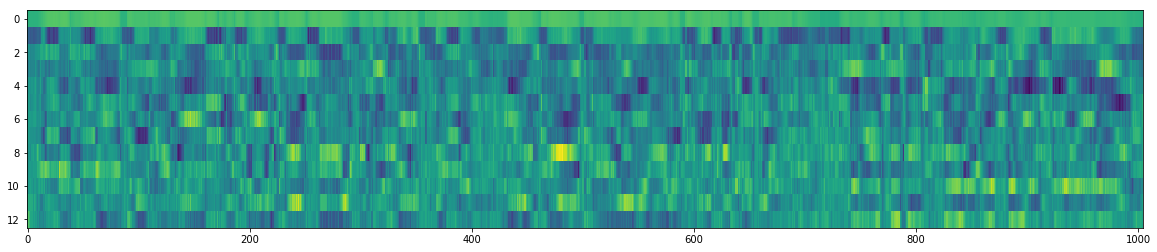

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
ax.imshow(np.transpose(mfccs), interpolation='nearest', aspect='auto')

In [11]:
IPython.display.Audio(data=audio, rate=16000)

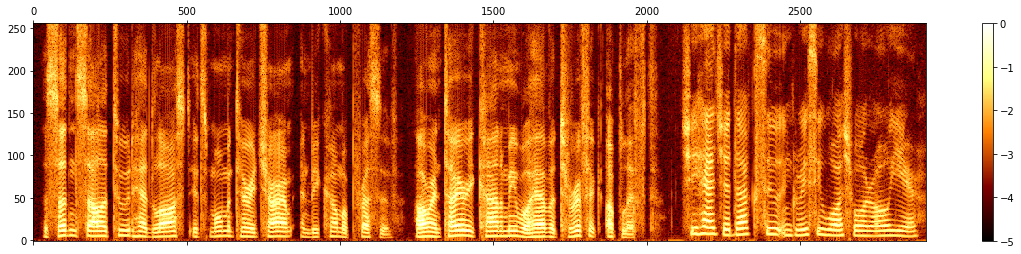

In [15]:
wav_spectrogram = np.concatenate(spectograms[::3]) # reconstruct spectogram from windows

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(wav_spectrogram), interpolation='nearest', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)

In [ ]:
recovered_audio = invert_pretty_spectrogram(spectograms)
IPython.display.Audio(data=recovered_audio, rate=16000)